# Detecting Blindness with Deep Learning
> Using CNNs to detect diabetic retinopathy in retina photos

- toc: true 
- badges: true
- comments: true
- author: Nikita Kozodoi
- categories: [python, deep learning, computer vision]
- image: images/posts/retina.png

# 1. Overview

Can deep learning help to detect blindness?

This blogpost describes the pipeline of the project that develops a convolutional neural network (CNN) for predicting the severity of the diabetic retinopathy based on the patient's retina photograph. The project was completed within the scope of the [Udacity Machine Learning Engineer](https://confirm.udacity.com/LMMJDA7C) nano-degree program and the [Kaggle competition](https://www.kaggle.com/c/aptos2019-blindness-detection/data) hosted by the Asia Pacific Tele-Ophthalmology Society (APTOS).

The blogpost provides a project walkthrough covering the most important modeling steps.
- data exploration and image preprocessing to normalize images from different clinics
- using transfer learning to pre-train CNN on a large data set and fine-tune the model on target domain
- implementing techniques such as learnung rate scheduler, test-time augmentation and others to improve the performance

The modeling is done in `PyTorch`. All Jupyter notebooks and a PDF report are [available on Github](https://github.com/kozodoi/Udacity_Blindness_Detection).

# 2. Motivation

Diabetic retinopathy (DR) is one of the leading causes of vision loss. The World Health Organization reports that more than 300 million people worldwide have diabetes (Wong et al 2016). According to a recent study from International Diabetes Federation, the global prevalence of DR among the individuals with diabetes for the period from 2015 to 2019 was at more than 25% (Thomas et al 2019). The disease prevalence has been rising rapidly in developing countries.

Early detection and treatment are crucial steps towards preventing DR. The screening procedure requires a trained clinical expert to examine the fundus photographs of the patient's retina. This creates delays in diagnosis and treatment of the disease. This is especially relevant for developing countries, which often lack qualified medical stuff to perform the diagnosis. Automated detection of DR can speed up the efficiency and coverage of the screening programs.

# 3. Data preparation

Data exploration and preprocessing are very important steps that are frequently underestimated. Reagrdless of the application domain, the quality of the input data can have a strong impact on the resulting performance of the developed machine learning models. Therefore, it is crucial to take some time to look at the data and think about possible issues that should be addressed before moving on to the modeling stage.

## Data exploration

The data set is provided by APTOS and is available for the download at the [competition's website](https://www.kaggle.com/c/aptos2019-blindness-detection/data). The data set includes 3,662 labeled retina images of clinical patients and a test set with 1,928 images with unknown labels. 

The images are taken using a fundus photography technique and labeled by a clinical expert. The integer labels indicate the severity of DR on a scale from 0 to 4, where 0 indicates no disease and 5 is the proliferative stage of DR.

First, let us import the data and look at the class ditribution.

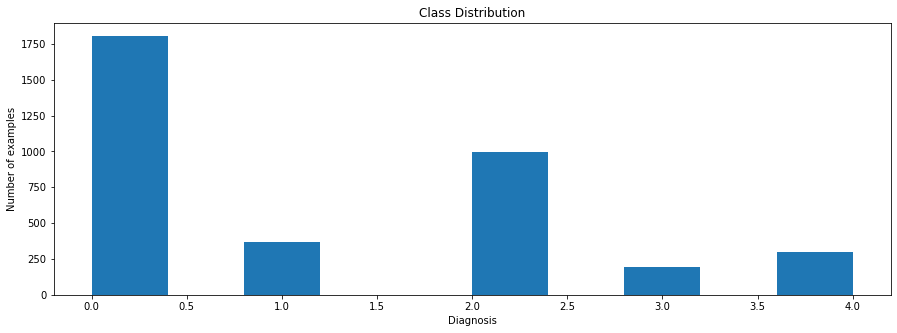

In [4]:
#collapse-hide

############ LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns



########## SETTINGS

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



############ CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))



############ CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

# export
plt.savefig('fig_class_distribution.pdf')

The data set is imbalanced. 49% of the images are healthy patients. The remaining 51\% are pictures with different stages of DR. The least common class is 3 (severe stage) with only 5% of the total examples. 

The data is collected from multiple Indian clinics using a variety of different camera models, which creates discrepancies in the image resolution, aspect ratio and other parameters. This is demonstrated in a figure below, where we plot the histograms of image width, height and aspect ratio. A high variety in the image parameters requires to be accounted for during the prepossessing.

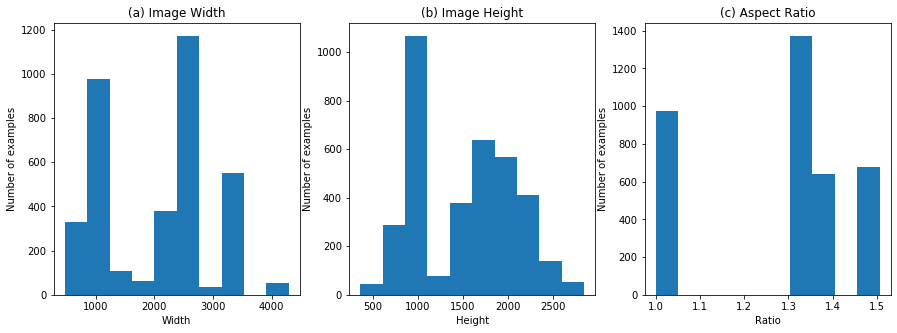

In [8]:
#collapse-show

# import loop
image_stats = []
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']



############ HISTOGRAMS

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

# export
plt.savefig('fig_size_distribution.pdf')

Now, let us take a look at the actual images. The code below creates the `EyeData` dataset class to import the images using `opencv` library. We also create a `DataLoader` object to load sample images and visualize the first batch.

In [ ]:
#collapse-hide

############ DATASET

# image preprocessing function
def prepare_image(path, image_size = 256):
    
    # import
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resize
    image = cv2.resize(image, (int(image_size), int(image_size)))

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image
  
    
# dataset class:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)  
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
    
############ EXAMINE SAMPLE BATCH

# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

![](images/fig_eye_example.png)

The illustration further emphasizes the difference between the retina photographs in terms of aspect ratio, lighting conditions and camera quality. In practice, the severity of DR is diagnosed by the presence of different visual cues on the retina photographs. This includes signs like abnormal blood vessels, hard exudates and so-called "cotton wool" spots. Comparing the sample images, we can see the presence of exudates and "cotton wool" spots on some of the retina photographs of sick patients.

## Image preprocessing

Visual inspection of retina images suggests that images taken from cameras with different aspect ratios result in some images having large black areas around the eye. The black areas do not contain information relevant for prediction and can be cropped. However, we see that the size of black areas varies from one image to another. To address this, we develop a cropping function that converts the image to grayscale and marks black areas based on the pixel intensity. Next, we find a mask of the image by selecting rows and columns in which all pixels exceed the intensity threshold. This helps to remove vertical or horizontal rectangles filled with black similar to the ones observed in the upper-right image in Figure 4. After removing the black stripes, we resize the images to the same height and width.

Another issue is the eye shape. Depending on the image parameters, some eyes appear to have a circular form, whereas others look like ovals. As the size and shape of items located in the retina determine the disease severity, it is crucial to standardize the eye shape as well. To do so, we develop another cropping function that makes a circular crop of a particular radius around the center of the image.

Finally, we correct for the lightning and brightness discrepancies by smoothing the images using a Gaussian filter. 

The snippet below provides the updated `prepare_image()` function that incorporates the discussed preprocessing steps.

In [5]:
#collapse-show

############ PREPROCESSING FUNCTIONS

##### image preprocessing function
def prepare_image(path, sigmaX = 10, do_random_crop = False):
    
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image


##### automatic crop of black areas
def crop_black(img, tol = 7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img
        
        
##### circular crop around image center
def circle_crop(img, sigmaX = 10):   
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 


##### random crop
def random_crop(img, size = (0.9, 1)):

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

Nesxt, we define a new `EyeData` class that uses the new processing functions and visualize a batch of sample images after corrections.

In [ ]:
#collapse-show

############ DATASET
    
# dataset class:
class EyeData(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)  
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}



############ EXAMINE SAMPLE BATCH

image_size = 256


# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

# export plot
plt.savefig('../figures/fig_data_example.pdf')

![](images/fig_eye_fixed.png)

This looks much better! Comparing the retina images to the ones before the preprocessing, we can see that the apparent discrepancies between the photographs are now fixed. The eyes now have a similar circular shape and the color scheme is more consistent. This should help the model to detect the signs of the DR on the photographs.

Check out [this notebook](https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy) by Nakhon Ratchasima for more ideas on the image preprocessing for retina photographs. The preprocessing functions used in this project are largely inspired by his work suring the competition.

# 4. Modeling

This project develops a CNN-based deep learning model for the DR severity classification task. CNNs achieve state-of-the-art performance in computer vision tasks such as image classification. Recent medical research also shows a high potential of applying CNNs in the DR classification task (Gulshan et al 2016). Furthermore, using CNNs allows to take advantage of transfer learning techniques, which is relevant given a small sample size of the considered data set.

We employ the EfficientNet architecture for the CNN classifier. [EfficientNet](https://arxiv.org/abs/1905.11946) is one of the recent state-of-the-art CNN models in image classification (Tan et al 2019). EfficientNet encompasses 8 architecture variants (B0 to B7) which differ in the model complexity and default image size. 

The architecture of EfficientNet B0 is visualized below. We test multiple EfficientNet neural network architectures and use the one that demonstrates the best performance.

![](images/fig_imagenet.png)

The modeling pipeline consists of the three main stages outlined below:

- __Pre-training the model__. The target data set has a limited number of images (N = 3,662). Therefore, we pre-train the CNN model on a larger data set from the 2015 competition. 
- __Fine-tuning the model__. We fine-tune the pre-trained model on the main data set. We consider different variants of image augmentations to improve the model performance. We use cross-validation for data partitioning and make modeling decisions based on the performance observed on the out-of-fold predictions. 
- __Predicting labels of test images__. On the inference stage, we use saved weights from the base models trained on different combinations of training folds. We aggregate predictions from the base models and use test-time augmentation to further improve the predictive performance.

## Pre-training

Due to a small sample size of the data, we can not train a complex neural architecture from scratch. This is where transfer learning comes in handy. The idea of transfer learning is to pre-train a model on a different data set (source domain) and then fine-tune on the relevant data set (target domain).

A good candidate for the source domain is the [ImageNet database](http://www.image-net.org). Most published CNN models are trained on that data. However, the images in the ImageNet library are substantially different from the retina images that we want to classify. Although intializing the CNN with ImageNet weights might help the network to transfer the knowledge of basic image patterns such as shapes and edges, we still need to learn a lot from the target domain.

It turns out that APTOS has also hosted another Kaggle competition on the DR classification in 2015. The data set of the 2015 competition features 35,126 retina images labeled by a clinician using the same scale as the main data set. The data set has been used in the 2015 Diabetic Retinopathy Detection competition and is available for the download [here](https://www.kaggle.com/c/diabetic-retinopathy-detection/data).

Our final stretagy would be as foloows:
- Initialize weights from the model trained on the ImageNet database.
- Train the model on the 2015 data set to adjust weights.
- Fine-tune the model on the 2019 data set.

First, we enable GPU support (if available) and fix the random seeds. The function `seed_everything()` sets random seed for multiple libraries including `numpy` and `pytorch` to ensure reproducibility.

In [2]:
#collapse-show

# GPU check
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [ ]:
#collapse-show

# seed function
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# set seed
seed = 23
seed_everything(seed)

Let us take a quick look in the class distribution in the 2015 data set.

In [4]:
#collapse-show

# import data
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['id_code', 'diagnosis']
test = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))
print('-' * 15)
print(test['diagnosis'].value_counts(normalize = True))

(35126, 2) (3662, 2)
---------------
0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: diagnosis, dtype: float64
---------------
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


The imbalance in the 2015 data set is stronger than in the 2019 data: 73% of images represent healthy patients, whereas the most severe stage of the DR is only found in 2% of the images. To fight the imbalance, we will use the target 2019 data set as a validation sample.

We create two Dataset objects to enable different data augmentation on the training and inference stages: `EyeTrainData` and `EyeTestData`. The training data set include a random crop that is skipped for the test data.

In [ ]:
#collapse-hide
  
# dataset class: train
class EyeTrainData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.jpeg')
        image    = prepare_image(img_name, do_random_crop = True)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
# dataset class: test
class EyeTestData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name, do_random_crop = False)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

We use a batch size of 20 and set the image size of 256. The choice of these parameters is a trade-off between a predictive performance and resource capacity. Feel free to try larger image and batch sizes if you have resources available.

We use the following data augmentations during training:
- random horizontal flip (p = 0.5)
- random vertical flip (p = 0.5)
- random image rotation in the range of [-360 degrees, 360 degrees]

In [ ]:
#collapse-show

# parameters
batch_size = 20
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# create datasets
train_dataset = EyeTrainData(data      = train, 
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans)
valid_dataset = EyeTestData(data       = test, 
                            directory  = '../input/aptos2019-blindness-detection/train_images',
                            transform  = valid_trans)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 4)

Next, we instantiate the EfficentNet model. Let us use the B4 architecture, which is a trade-off between the training time and performance. We initialize the model weights using the parameters pre-trained on ImageNet by downloading the model architecture and weights in the `PyTorch` format. The convolutional part of the network responsible for feature extraction outputs a tensor with `1792` features. To adapt the trained EfficentNet to our task, we replace the last fully-connected classification layer with a `(1792, 5)` fully-connected layer.

The function `init_model()` instantiates the CNN model. The argument `train` ensures that we load the ImageNet weights on the training stage and turn off the gradient computation on the inference stage.

In [ ]:
#collapse-show

############ MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# initialization function
def init_model(train = True):
    
    ### training mode
    if train == True:
                 
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)
      
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b4')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False
            
            
    ### return model
    return model


# check architecture
model = init_model()
print(model)

Since we are dealing with a multiple classification problem, we use cross-entropy as a loss function. We implement `nn.CrossEntropyLoss()` function which combines logsoftmax and negative log-likelihood loss and applies them to the output of the last network layer.

Next, we define optimizer for the network. We use adaptive learning rate optimization algorithm (`Adam`) with a starting learning rate of 0.001. During training, we use a learning rate scheduler, which multiplies the learning rate by 0.5 after every 5 epochs. This helps to make smaller changes to the network weights when we are getting closer to the optimum. Weights of all network layers are optimized during the pre-training.

In [ ]:
#collapse-show

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# initialize model and send to GPU
model = init_model()
model = model.to(device)

After each training epoch, we validate the model on the validation examples. We extract class scores from the last fully-connected layer and predict the image class corresponding to the highest score. We use images from the main 2019 data set as a validation sample. This allows us to validate the network on the images from the main data set. We train the network for 15 epochs, tracking the validation loss and Cohen's kappa. If the kappa does not increase for 5 consecutive epochs, we terminate the training process and save model weights for the epoch which is associated with the highest validation kappa.

The modeling loop is provided in the snippet below.

In [13]:
#collapse-hide

# placeholders
oof_preds = np.zeros((len(test), 5))
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

# timer
cv_start = time.time()

# training and validation loop
for epoch in range(max_epochs):

    ##### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    ##### TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    ##### INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(valid_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    ##### EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    ##### EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        torch.save(model.state_dict(), '../models/model_{}.bin'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

        
# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.7140 | val_loss = 1.3364 | val_kappa = 0.7268 | 30.03 min
- epoch 2/15 | lr = 0.001 | trn_loss = 0.6447 | val_loss = 1.0670 | val_kappa = 0.8442 | 27.19 min
- epoch 3/15 | lr = 0.001 | trn_loss = 0.6203 | val_loss = 0.7667 | val_kappa = 0.7992 | 27.21 min
- epoch 4/15 | lr = 0.001 | trn_loss = 0.6020 | val_loss = 0.7472 | val_kappa = 0.8245 | 27.68 min
- epoch 5/15 | lr = 0.00025 | trn_loss = 0.5899 | val_loss = 0.7720 | val_kappa = 0.8541 | 29.42 min
- epoch 6/15 | lr = 0.0005 | trn_loss = 0.5542 | val_loss = 0.9255 | val_kappa = 0.8682 | 29.33 min
- epoch 7/15 | lr = 0.0005 | trn_loss = 0.5424 | val_loss = 0.8917 | val_kappa = 0.8763 | 29.91 min
- epoch 8/15 | lr = 0.0005 | trn_loss = 0.5359 | val_loss = 0.9555 | val_kappa = 0.8661 | 30.70 min
- epoch 9/15 | lr = 0.0005 | trn_loss = 0.5252 | val_loss = 0.8642 | val_kappa = 0.8778 | 28.76 min
- epoch 10/15 | lr = 0.000125 | trn_loss = 0.5184 | val_l

The training on the Kaggle GPU-enabled machine took us about 7 hours! Let us visualize the training and validation loss over the training epochs.

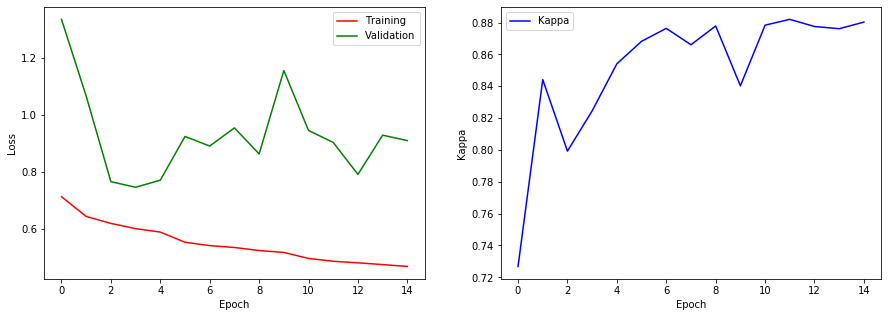

In [14]:
#collapse-show

########## PLOT LOSS AND KAPPA DYNAMICS

# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

# export plot
plt.savefig('../figures/fig_loss_pre_training.pdf')

The results suggest that the cross-entropy loss on validation sample reaches a minimum already after 3 epochs and does not improve with further training. At the same time, kappa continues to increase up to the 15th epoch. Since we use kappa to evaluate the quality of our solution, we save model weights after 15 epochs.

Below, we construct the confusion matrix of the trained model on validation set. The numbers in the table cells are percentages. According to the results, the model does a poor job in distinguishing the mild and moderate stages of DR: 86\% of images with mild DR are classified as moderate DR by the model. The best performance is observed for classifying the retina photographs of healthy people. Overall, we see that the model tends to confuse nearby severity stages but rarely missclassifies the proliferate and mild stages.

In [ ]:
#collapse-show

########## CONFUSION MATRIX

# rounding
oof_preds_round = oof_preds.argmax(axis = 1)
coef = [0.5, 1.5, 2.5, 3.5]
for i, pred in enumerate(oof_preds_round):
    if pred < coef[0]:
        oof_preds_round[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds_round[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds_round[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds_round[i] = 3
    else:
        oof_preds_round[i] = 4

# construct confusion matrx
cm = confusion_matrix(test['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
plt.savefig('../figures/fig_cm_pre_training.pdf')

![](images/fig_cm_pre_training.png)

## Fine-tuning

The fine-tuning on the main data set is performed using cross-validation with 4 folds. To ensure that we have enough examples of each class in the training sample, we perform cross-validation with stratification. On each iteration, we instantiate an EfficientNet B4 model with the same architecture as described in the previous section. Next, we load the saved weights from the model pre-trained on the supplementary data set. We freeze all network layers except for the last fully-connected classification layer. The weights in this layer are fine-tuned during training. 

As on the pre-training stage, we use `Adam` optimizer with a learning rate of 0.001 and implement a learning rate scheduler which multiplies the learning rate by 0.5 after every 5 epochs. We also track the model performance on the validation fold and stop the training if kappa does not increase for 5 consecutive epochs. This process is repeated for each of the 4 folds, and the best model weights are saved for each combination of the training folds.

After running the cross-validation loop, we aggregate the model performance including validation loss and kappa over all out-of-fold examples from validation folds. This provides the estimate of the model performance.

In [4]:
#collapse-hide

############ CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))

(3662, 2) (1928, 2)
---------------
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


The `init_model()` function needs to be updated. First, we now load the weights saved on the pre-training stage. Second, we freeze the first layers of the network in the training regime to make sure that fine-tuning is only performed on the last classification layer.

In [ ]:
#collapse-show

############ MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# initialization function
def init_model(train = True, trn_layers = 2):
    
    ### training mode
    if train == True:
                 
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)
        model.load_state_dict(torch.load('../models/model_{}.bin'.format(model_name, 1)))   
        
        # freeze first layers
        for child in list(model.children())[:-trn_layers]:
            for param in child.parameters():
                param.requires_grad = False
        
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)
        model.load_state_dict(torch.load('../models/model_{}.bin'.format(model_name, 1)))   

        # freeze all layers
        for param in model.parameters():
            param.requires_grad = False
            
            
    ### return model
    return model


# check architecture
model = init_model()

The training loop is now wrapped into a cross-validation loop.

In [13]:
#collapse-hide

########## VALIDATION SETTINGS

# no. folds
num_folds = 4

# creating splits
skf    = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = seed)
splits = list(skf.split(train['id_code'], train['diagnosis']))

# placeholders
oof_preds = np.zeros((len(train), 1))

# timer
cv_start = time.time()



############ PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5



########## CROSS-VALIDATION LOOP
for fold in tqdm(range(num_folds)):
    
    
    ####### DATA PREPARATION

    # display information
    print('-' * 30)
    print('FOLD {}/{}'.format(fold + 1, num_folds))
    print('-' * 30)

    # load splits
    data_train = train.iloc[splits[fold][0]].reset_index(drop = True)
    data_valid = train.iloc[splits[fold][1]].reset_index(drop = True)

    # create datasets
    train_dataset = EyeTrainData(data      = data_train, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = train_trans)
    valid_dataset = EyeTrainData(data      = data_valid, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = valid_trans)

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = True, 
                                               num_workers = 4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = False, 
                                               num_workers = 4)
    
    
    ####### MODEL PREPARATION
    
    # placeholders
    val_kappas = []
    val_losses = []
    trn_losses = []
    bad_epochs = 0
    
    # load best OOF predictions
    if fold > 0:
        oof_preds = oof_preds_best.copy()
    
    # initialize and send to GPU
    model = init_model(train = True)
    model = model.to(device)

    # optimizer
    optimizer = optim.Adam(model._fc.parameters(), lr = eta)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)
    
    
    ####### TRAINING AND VALIDATION LOOP
    for epoch in range(max_epochs):

        ##### PREPARATION

        # timer
        epoch_start = time.time()

        # reset losses
        trn_loss = 0.0
        val_loss = 0.0

        # placeholders
        fold_preds = np.zeros((len(data_valid), 1))


        ##### TRAINING

        # switch regime
        model.train()
        
        # loop through batches
        for batch_i, data in enumerate(train_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)
            optimizer.zero_grad()

            # forward and backward pass
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss  = criterion(preds, labels)
                loss.backward()
                optimizer.step()

            # compute loss
            trn_loss += loss.item() * inputs.size(0)


        ##### INFERENCE
        
        # initialize
        model.eval()

        # loop through batches
        for batch_i, data in enumerate(valid_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)

            # compute predictions
            with torch.set_grad_enabled(False):
                preds = model(inputs).detach()
                _, class_preds = preds.topk(1)
                fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = class_preds.cpu().numpy()

            # compute loss
            loss      = criterion(preds, labels)
            val_loss += loss.item() * inputs.size(0)

        # save predictions
        oof_preds[splits[fold][1]] = fold_preds
        
        # scheduler step
        scheduler.step()


        ##### EVALUATION

        # evaluate performance
        fold_preds_round = fold_preds
        val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')
        
        # save perfoirmance values
        val_kappas.append(val_kappa)
        val_losses.append(val_loss / len(data_valid))
        trn_losses.append(trn_loss / len(data_train))

        
        ##### EARLY STOPPING
        
        # display info
        print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
            epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
            trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
            (time.time() - epoch_start) / 60))
        
        # check if there is any improvement
        if epoch > 0:       
            if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
                bad_epochs += 1
            else:
                bad_epochs = 0

        # save model weights if improvement
        if bad_epochs == 0:
            oof_preds_best = oof_preds.copy()
            torch.save(model.state_dict(), '../models/model_{}_fold{}.bin'.format(model_name, fold + 1))

        # break if early stop
        if bad_epochs == early_stop:
            print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break

        # break if max epochs
        if epoch == (max_epochs - 1):
            print('Did not meet early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break
        

# load best predictions
oof_preds = oof_preds_best
            
# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

------------------------------
FOLD 1/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6279 | val_loss = 0.5368 | val_kappa = 0.8725 | 7.30 min
- epoch 2/15 | lr = 0.001 | trn_loss = 0.5699 | val_loss = 0.5402 | val_kappa = 0.8662 | 7.25 min
- epoch 3/15 | lr = 0.001 | trn_loss = 0.5572 | val_loss = 0.5380 | val_kappa = 0.8631 | 7.31 min
- epoch 4/15 | lr = 0.001 | trn_loss = 0.5482 | val_loss = 0.5357 | val_kappa = 0.8590 | 7.29 min
- epoch 5/15 | lr = 0.00025 | trn_loss = 0.5658 | val_loss = 0.5357 | val_kappa = 0.8613 | 7.25 min
- epoch 6/15 | lr = 0.0005 | trn_loss = 0.5537 | val_loss = 0.5346 | val_kappa = 0.8604 | 7.28 min
Early stopping. Best results: loss = 0.5346, kappa = 0.8604 (epoch 6)

------------------------------
FOLD 2/4
------------------------------
Loaded pretrained weights for efficientnet-b4
- epoch 1/15 | lr = 0.001 | trn_loss = 0.6535 | val_loss = 0.5295 | val_kappa = 0.8767 | 7.24 min
- epoc

The results indicate that after pre-training, the model converges quickly during fine-tuning. The best validation performance is obtained after 3 to 7 training epochs depending on a fold.

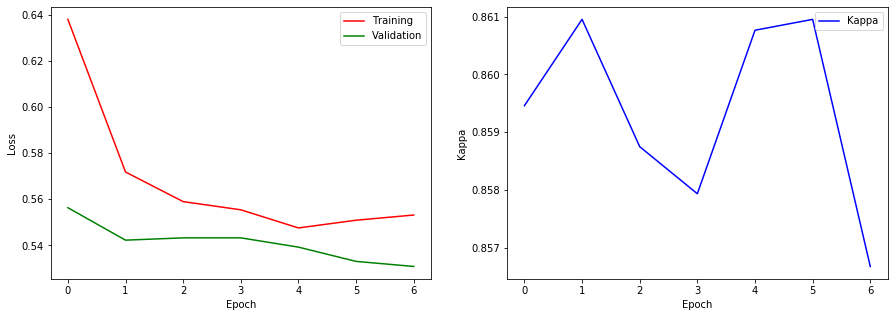

In [14]:
#collapse-hide

########## PLOT LOSS AND KAPPA DYNAMICS

# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

# export plot
plt.savefig('../figures/fig_loss_fine_tuning.pdf')

Let us visualize the confusion matrix of the best model after fine tuning. The matrix illustrates the advantages of the fine-tuned model over the pre-trained CNN and indicates a better performance in classifying mild stages of the DR. However, we also observe that the model classifies too many examples as a moderate stage of DR (class = 2). We try to address this issue on the inference stage by manipulating the thresholds.

In [ ]:
#collapse-hide

########## CONFUSION MATRIX

# construct confusion matrx
oof_preds_round = oof_preds.copy()
cm = confusion_matrix(train['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
plt.savefig('../figures/fig_cm_fine_tuning.pdf')

![](images/fig_cm_fine_tuning.png)

# 4. Inference

The model predictions for the test sample are obtained by aggregating the predictions from the base models trained during the cross-validation loop. To do so, we extract class scores from the last fully-connected layer and define class predictions as the classes with the maximal predicted score out of 5 classes. Next, we average predictions of the 4 EfficientNet models trained on different combinations of the training folds. We also use test-time augmentations by creating 4 versions of the test images with random augmentations (horizontal and vertical flips) and average predictions over the two image variants. The final prediction is therefore the average of 4 models $\times$ 4 test image variants.

In [6]:
#collapse-hide

############ TRANSFORMATIONS

# parameters
batch_size = 25
image_size = 256

# test transformations
test_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])


############ DATA LOADER

# create dataset
test_dataset = EyeTestData(data      = test, 
                           directory = '../input/aptos2019-blindness-detection/test_images',
                           transform = test_trans)

# create data loader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size  = batch_size, 
                                          shuffle     = False, 
                                          num_workers = 4)


############ MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# initialization function
def init_model(train = True, trn_layers = 2):
    
    ### training mode
    if train == True:
                 
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 5)

        # freeze first layers
        for child in list(model.children())[:-trn_layers]:
            for param in child.parameters():
                param.requires_grad = False
        
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b4')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze all layers
        for param in model.parameters():
            param.requires_grad = False
            
            
    ### return model
    return model


# check architecture
model = init_model(train = False)

In [11]:
#collapse-show

########## INFERENCE LOOP

# validation settings
num_folds = 4
tta_times = 4

# placeholders
test_preds = np.zeros((len(test), num_folds))
cv_start   = time.time()

# prediction loop
for fold in tqdm(range(num_folds)):
    
    # load model and sent to GPU
    model = init_model(train = False)
    model.load_state_dict(torch.load('../models/model_{}_fold{}.bin'.format(model_name, fold + 1)))
    model = model.to(device)
    model.eval()
    
    # placeholder
    fold_preds = np.zeros((len(test), 1))
    
    # loop through batches
    for _ in range(tta_times):
        for batch_i, data in enumerate(test_loader):
            inputs = data['image']
            inputs = inputs.to(device, dtype = torch.float)
            preds = model(inputs).detach()
            _, class_preds = preds.topk(1)
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] += class_preds.cpu().numpy()
    fold_preds = fold_preds / tta_times
    
    # aggregate predictions
    test_preds[:, fold] = fold_preds.reshape(-1)

# print performance
test_preds_df = pd.DataFrame(test_preds.copy())
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))


Finished in 13.89 minutes


Let us have a look at the distribution of predictions.

In [ ]:
#collapse-hide

########## SUMMARIZE PREDICTIONS

# show predictions
print('-' * 45)
print('PREDICTIONS')
print('-' * 45)
print(test_preds_df.head())

# show correlation
print('-' * 45)
print('CORRELATION MATRIX')
print('-' * 45)
print(np.round(test_preds_df.corr(), 4))
print('Mean correlation = ' + str(np.round(np.mean(np.mean(test_preds_df.corr())), 4)))

# show stats
print('-' * 45)
print('SUMMARY STATS')
print('-' * 45)
print(test_preds_df.describe())

# show prediction distribution
print('-' * 45)
print('ROUNDED PREDICTIONS')
print('-' * 45)
for f in range(num_folds):
    print(np.round(test_preds_df[f]).astype('int').value_counts(normalize = True))
    print('-' * 45)

# plot densities
test_preds_df.plot.kde()

![](images/fig_class_dist.png)

The model classifies a lot of images as moderate DR (class = 2).

To slightly reduce the number of such examples, we can change thresholds used to round the averaged predictions into classes. We use the following vector of thresholds: [0.5, 1.75, 2.25, 3.5]. The final prediction is set to zero if the average value is below 0.5; set to one if the average value lies in [0.5, 1.75), etc. This reduces the share of images classified as moderate DR in the test sample.

In [13]:
#collapse-show

# aggregate predictions
test_preds = test_preds_df.mean(axis = 1).values

# set cutoffs
coef = [0.5, 1.75, 2.25, 3.5]

# rounding
for i, pred in enumerate(test_preds):
    if pred < coef[0]:
        test_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_preds[i] = 3
    else:
        test_preds[i] = 4

# 5. Closing words

This blogpost provides a complete walk-through the project on detecting blindness in the retina images using CNNs. We used image preprocessing to reduce discrepancies across images taken in different clinics, used transfer learning to leverage knowledge learned on larger data sets and implemented techniques like test-time augmentation, learning rate scheduler and others.

If you are still reading this blogpost, you might be wondering about potential ways to further improve the performance. There are multiple ways to do that. First, employing a larger neural network architecture and extending the number of training epochs on the pre-training stage has a high potential for demonstrating a better performance. The strongest benchmark uses EfficientNet B5 architecture, which is deeper compared to the B4 model used in our solution. At the same time, this direction would require more computing power, which might not be optimal when considering the possible use of the automated retina image classification in practice.

Second, image preprocessing can be further improved. During the refinement process, the largest performance gains were attributed to including certain preprocessing steps when working with image data. This is a more efficient way to further improve the predictive performance.

Finally, the best solutions of other teams in the corresponding Kaggle competition rely on model ensembles trained on different image sizes and/or model architectures. Incorporating multiple heterogeneous models and blending their predictions could also improve the predictive performance of the proposed solution.